## Загрузка данных

In [1]:
!pip install scorch

In [2]:
conda install -c conda-forge skorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - skorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    joblib-1.2.0               |     pyhd8ed1ab_0         205 KB  conda-forge
    scikit-learn-0.24.2        |   py39h4dfa638_0         7.6 MB  conda-forge
    scipy-1.6.3                |   py39hee8e79c_0        20.7 MB  conda-forge
    skorch-0.9.0               |     pyh7b7c402_0          93 KB  conda-forge
    tabulate-0.9.0             |     pyhd8ed1ab_1          35 KB  conda-forge
    threadpoolct

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import random
from math import ceil
import warnings
import scorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [4]:
# загрузка данных из файла
df = pd.read_csv('/datasets/6_class.csv', index_col=0)
# получения общей информации
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


None

In [5]:
# получение первых строк
display(df.head())
# расчет наличия пропусков
display(df.isna().count()/df.shape[0])

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Temperature (K)           1.0
Luminosity(L/Lo)          1.0
Radius(R/Ro)              1.0
Absolute magnitude(Mv)    1.0
Star type                 1.0
Star color                1.0
dtype: float64

### Вывод

- Пропуски в данных не обнаружены
- Пять столбцов имеют числовой формат, один столбец имеет текстовый формат

## Предобработка и анализ данных

,Temperature (K)
count,240.000000
mean,10497.462500
std,9552.425037
min,1939.000000
25%,3344.250000
50%,5776.000000
75%,15055.500000
max,40000.000000


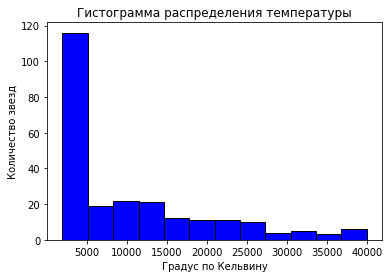

In [6]:
# получение информации о данных столбца с температурой
display(pd.DataFrame(df['Temperature (K)'].describe()))
# построение графика для столбца с температурой
plt.hist(df['Temperature (K)'], color = 'blue', edgecolor = 'black', bins = 12);
plt.title('Гистограмма распределения температуры')
plt.xlabel('Градус по Кельвину')
plt.ylabel('Количество звезд');

,Luminosity(L/Lo)
count,240.000000
mean,107188.361635
std,179432.244940
min,0.000080
25%,0.000865
50%,0.070500
75%,198050.000000
max,849420.000000


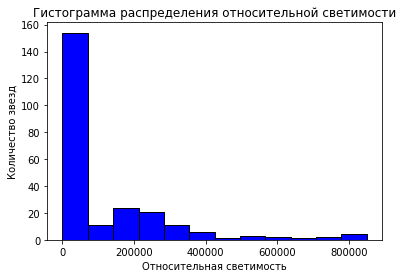

In [7]:
# получение информации о данных столбца с относительной светимости
display(pd.DataFrame(df['Luminosity(L/Lo)'].describe()))
# построение графика для столбца с относительной светимостью
plt.hist(df['Luminosity(L/Lo)'], color = 'blue', edgecolor = 'black', bins = 12);
plt.title('Гистограмма распределения относительной светимости')
plt.xlabel('Относительная светимость')
plt.ylabel('Количество звезд');

,Radius(R/Ro)
count,240.000000
mean,237.157781
std,517.155763
min,0.008400
25%,0.102750
50%,0.762500
75%,42.750000
max,1948.500000


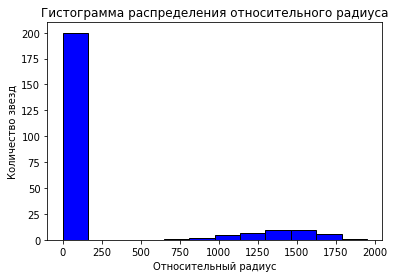

In [8]:
# получение информации о данных столбца с относительным радиусом
display(pd.DataFrame(df['Radius(R/Ro)'].describe()))
# построение графика для столбца с относительным радиусом
plt.hist(df['Radius(R/Ro)'], color = 'blue', edgecolor = 'black', bins = 12);
plt.title('Гистограмма распределения относительного радиуса')
plt.xlabel('Относительный радиус')
plt.ylabel('Количество звезд');

,Absolute magnitude(Mv)
count,240.000000
mean,4.382396
std,10.532512
min,-11.920000
25%,-6.232500
50%,8.313000
75%,13.697500
max,20.060000


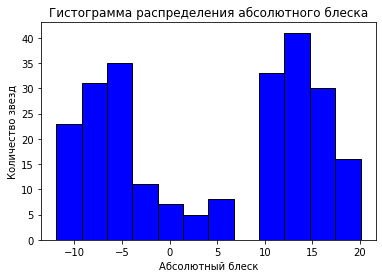

In [9]:
# получение информации о данных столбца с абсолютным блеском звезды
display(pd.DataFrame(df['Absolute magnitude(Mv)'].describe()))
# построение графика для столбца с абсолютным блеском звезды
plt.hist(df['Absolute magnitude(Mv)'], color = 'blue', edgecolor = 'black', bins = 12);
plt.title('Гистограмма распределения абсолютного блеска')
plt.xlabel('Абсолютный блеск')
plt.ylabel('Количество звезд');

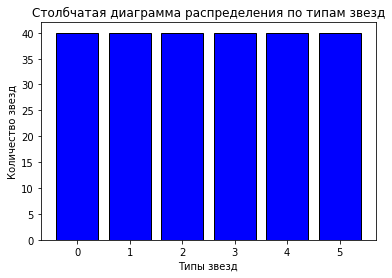

In [10]:
# сводная таблоица с количеством по типам звезд
pivot_df1 = df.pivot_table(index=['Star type'], values=['Temperature (K)'], aggfunc=['count'])
pivot_df1.columns = ['star_type_count']
# построение графика для столбца с типом звезды
plt.bar(x = pivot_df1.index, height = pivot_df1['star_type_count'], color = 'blue', edgecolor = 'black');
plt.title('Столбчатая диаграмма распределения по типам звезд')
plt.xlabel('Типы звезд')
plt.ylabel('Количество звезд');

In [11]:
# вывод уникальных значений
display(df['Star color'].unique())
# удалим пробелы в столбце с цветом звезд
df['Star color'] = df['Star color'].map(str.strip)
# приведение к нижнему регистру
df['Star color'] = df['Star color'].map(str.lower)
# замена тире на пробел
df['Star color'] = df['Star color'].str.replace('-', ' ')
# замена whitish на white
df['Star color'] = df['Star color'].str.replace('whitish', 'white')
# замена yellowish на yellow
df['Star color'] = df['Star color'].str.replace('yellowish', 'yellow')
# замена white yellowish на yellowish white
df['Star color'] = df['Star color'].str.replace('white yellow', 'yellow white')

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

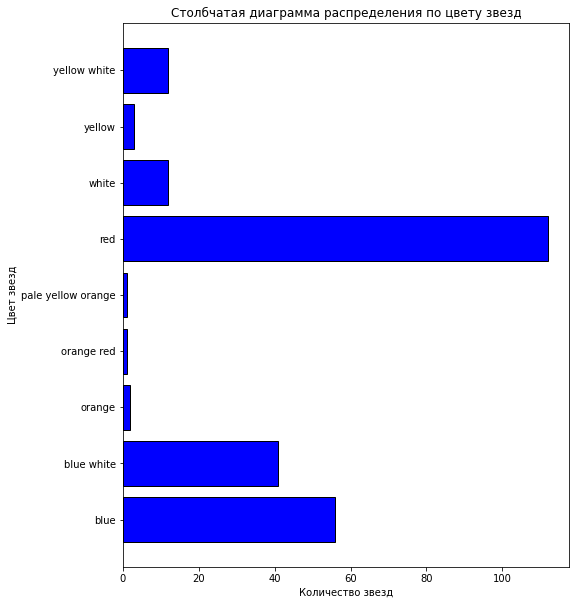

In [12]:
# сводная таблоица с количеством по цвету звезд
pivot_df2 = df.pivot_table(index=['Star color'], values=['Temperature (K)'], aggfunc=['count'])
pivot_df2.columns = ['star_color_count']
# построение графика для столбца с цветом звезды
plt.figure(figsize=(8, 10))
plt.barh(y = pivot_df2.index, width = pivot_df2['star_color_count'], color = 'blue', edgecolor = 'black');
plt.title('Столбчатая диаграмма распределения по цвету звезд')
plt.xlabel('Количество звезд')
plt.ylabel('Цвет звезд');

### Вывод

1. Самая распространенная температура у звезд не превышает 5000 К 
2. Самая распространенная относительная светимость не превышает показателя в 100 000
3. Самый распространенный относительный радиус не превышает показателя в 100
4. Абсолютный блеск имеет два пика, около `-6` первый и возле `13` второй
5. Типы звезд представлены в одинаковом количестве по 40 шт на каждый (от 0 до 6)
6. В столбце с цветом звезды, наиболее часто встречающиеся цвета это `red`, `blue white` и `blue`. А также внесены следующие изменения:
    - убраны пробелы
    - текст приведен к нижнему регистру
    - `whitish` преобразован в `white`
    - `yellowish` преобразован в `yellow`
    - `white yellow` преобразован в `yellow white`

## Подготовка данных

### Подготовка выборок

In [13]:
# создадим копию таблицы
new_df = df.copy()
# обозначим признаки и цели
new_df = new_df.rename(columns={'Temperature (K)': 'temperature'})
features = new_df.drop('temperature', axis=1)
target = new_df['temperature']
# разделим на выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=571)
# сохраним копию выборки для построения графика "факт-прогноз"
features_test = X_test.copy()
target_test = y_test.copy()
target_test2 = target_test.copy()
# выведем размерности выборок на экран
display(f'X_train: {X_train.shape}')
display(f'X_test: {X_test.shape}')
display(f'y_train: {y_train.shape}')
display(f'y_test: {y_test.shape}')

'X_train: (192, 5)'

'X_test: (48, 5)'

'y_train: (192,)'

'y_test: (48,)'

### Масштабирование признаков

In [14]:
# обозначим категориальные и количественные признаки
categorical = ['Star type', 'Star color']
numeric = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

In [15]:
# уберем предупреждения
warnings.filterwarnings('ignore')
# используем scaler для преобразования числовых данных
scaler = StandardScaler()  
scaler.fit(X_train[numeric]) 
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
display(X_train.head(3))
display(X_test.head(3))

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
171,0.167811,2.321393,-1.198643,5,red
68,-0.593145,-0.444959,1.224827,0,red
136,-0.593145,-0.444722,0.659951,1,red


,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
73,-0.593145,-0.444507,0.708288,1,red
11,-0.593145,-0.444456,0.694071,1,red
111,0.101641,1.744697,-1.447909,5,red


### Категоризирование признаков

In [16]:
# используем ohe для преобразования категориальных данных
ohe = OneHotEncoder(handle_unknown='error') 
# преобразуем обучающую выборку
X_train_cop = X_train.copy()
X_train_cop = X_train_cop.reset_index(drop=True)
transformed_train = ohe.fit_transform(X_train_cop[categorical])
transformed_train = pd.DataFrame(transformed_train.toarray(), columns=(list(ohe.categories_[0]) + list(ohe.categories_[1])))
X_train_new = X_train_cop.join(transformed_train)
X_train_new = X_train_new.drop(categorical, axis=1)
X_train_new.columns = ['luminosity', 'radius', 'abs_magnitude', 'star_type_0', 'star_type_1', 
                       'star_type_2', 'star_type_3', 'star_type_4', 'star_type_5', 'color_blue', 
                       'color_blue_white', 'color_orange','color_orange_red', 'color_pale_yellow_orange', 
                       'color_red', 'color_white', 'color_yellow', 'color_yellow_white']
X_train_new = X_train_new.set_index(X_train.index)
# преобразуем тестовую выборку
X_test_cop = X_test.copy()
X_test_cop = X_test_cop.reset_index(drop=True)
transformed_test = ohe.transform(X_test_cop[categorical])
transformed_test = pd.DataFrame(transformed_test.toarray(), columns=(list(ohe.categories_[0]) + list(ohe.categories_[1])))
X_test_new = X_test_cop.join(transformed_test)
X_test_new = X_test_new.drop(categorical, axis=1)
X_test_new.columns = ['luminosity', 'radius', 'abs_magnitude', 'star_type_0', 'star_type_1', 
                       'star_type_2', 'star_type_3', 'star_type_4', 'star_type_5', 'color_blue', 
                       'color_blue_white', 'color_orange','color_orange_red', 'color_pale_yellow_orange', 
                       'color_red', 'color_white', 'color_yellow', 'color_yellow_white']
X_test_new = X_test_new.set_index(X_test.index)
display(X_train_new.head(3))
display(X_test_new.head(3))

,luminosity,radius,abs_magnitude,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,color_blue,color_blue_white,color_orange,color_orange_red,color_pale_yellow_orange,color_red,color_white,color_yellow,color_yellow_white
171,0.167811,2.321393,-1.198643,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68,-0.593145,-0.444959,1.224827,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
136,-0.593145,-0.444722,0.659951,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,luminosity,radius,abs_magnitude,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,color_blue,color_blue_white,color_orange,color_orange_red,color_pale_yellow_orange,color_red,color_white,color_yellow,color_yellow_white
73,-0.593145,-0.444507,0.708288,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11,-0.593145,-0.444456,0.694071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111,0.101641,1.744697,-1.447909,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# преобразуем в тензоры
X_train_new = torch.FloatTensor(X_train_new.values)
X_test_new = torch.FloatTensor(X_test_new.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)
# выведем размерности тензоров на экран
display('X_train_new', X_train_new.shape)
display('X_test_new', X_test_new.shape)
display('y_train', y_train.shape)
display('y_test', y_test.shape)

'X_train_new'

torch.Size([192, 18])

'X_test_new'

torch.Size([48, 18])

'y_train'

torch.Size([192])

'y_test'

torch.Size([48])

### Вывод

- Проведено масштабирование колонок с относительной светимостью, относительным радиусом и абсолютным блеском звезды
- Проведено категоризирование колонок с типом и цветом звезд
- Выборки разделены на обучающую и тестовую, а также приведены к типу `torch`

## Построение базовой нейронной сети

In [18]:
# зафиксируем рандом, для повторяемости результатов
random.seed(571)
np.random.seed(571)
torch.manual_seed(571)
# определим количество нейронов для базовой модели
n_in_neurons = int(X_train_new.shape[1])
n_hidden_neurons_1 = 324    #26-20-18
n_hidden_neurons_2 = 324    #52-40-18
n_hidden_neurons_3 = 324
n_hidden_neurons_4 = 324
n_hidden_neurons_5 = 324
n_out_neurons = 1
# выведем на экран
display(f'Количество нейронов на входном слое: {n_in_neurons}')
display(f'Количество нейронов на первом скрытом слое: {n_hidden_neurons_1}')
display(f'Количество нейронов на втором скрытом слое: {n_hidden_neurons_2}')
display(f'Количество нейронов на третьем скрытом слое: {n_hidden_neurons_3}')
display(f'Количество нейронов на четвертом скрытом слое: {n_hidden_neurons_4}')
display(f'Количество нейронов на пятом скрытом слое: {n_hidden_neurons_5}')
display(f'Количество нейронов на выходе: {n_out_neurons}')

'Количество нейронов на входном слое: 18'

'Количество нейронов на первом скрытом слое: 324'

'Количество нейронов на втором скрытом слое: 324'

'Количество нейронов на третьем скрытом слое: 324'

'Количество нейронов на четвертом скрытом слое: 324'

'Количество нейронов на пятом скрытом слое: 324'

'Количество нейронов на выходе: 1'

In [19]:
%%time
# архитектура сети с четырьмя скрытыми слоями
class Model_base(nn.Module):
    def __init__(self, neurons_hid1, neurons_hid2, neurons_hid3, neurons_hid4, neurons_hid5, activation_1, activation_2): 
        super(Model_base, self).__init__()
        self.layer1 = nn.Linear(18, n_hidden_neurons_1)
        self.act1 = activation_1
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation_1
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = activation_2
        self.layer4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = activation_2
        self.layer5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
        self.act5 = activation_2
        self.layer6 = nn.Linear(n_hidden_neurons_5, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.layer3(x)
        x = self.act3(x)
        x = self.layer4(x)
        x = self.act4(x)
        x = self.layer5(x)
        x = self.act5(x)
        x = self.layer6(x)
        return x   
    
# инициализация модели
model_first = Model_base(n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 
                         n_hidden_neurons_4, n_hidden_neurons_5, nn.ReLU(), nn.ReLU()) 

# добавление оптимизатора adam
optimizer = torch.optim.Adam(model_first.parameters(), lr=1.0e-3) 
# добаавление функции потерь
loss = nn.L1Loss()
# количество эпох
num_epochs = 301
# переменная для сравнения с предварительным результатом
best_rmse = 4500
# инициализация сети
for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = model_first.forward(X_train_new).flatten()
    loss_value = loss(preds, y_train)
    loss_value.backward()
    optimizer.step()
# расчет метрики для сотой и последней эпохи
    if epoch % 100 == 0:
        model_first.eval()
        test_preds = model_first.forward(X_test_new)
        rmse = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        display(f'epoch:{epoch}, rmse:{rmse}')
# запись промежуточного результата для получения наилучшего значения        
        if rmse < best_rmse:
            best_rmse = rmse
# вывод лучшей метрики на экран        
display('Лучшее значение RMSE:', round(best_rmse, 2))


'epoch:0, rmse:12928.986967276283'

'epoch:100, rmse:5221.481973539696'

'epoch:200, rmse:3978.101557275782'

'epoch:300, rmse:3881.1889930793113'

'Лучшее значение RMSE:'

3881.19

CPU times: user 10.4 s, sys: 29.3 ms, total: 10.4 s
Wall time: 10.6 s


In [20]:
# подготовка таблицы с данными
test_preds = test_preds.detach().numpy()
test_preds = pd.DataFrame(test_preds, index=features_test.index)
target_test = pd.DataFrame(target_test)
target_test = target_test.join(test_preds)
target_test.columns = ['temperature', 'predictions']
target_test.reset_index(drop= True , inplace= True )
display(target_test.head())

,temperature,predictions
0,3150,3199.692627
1,3129,3211.469238
2,3605,3292.575928
3,3095,3347.060303
4,10574,9572.486328


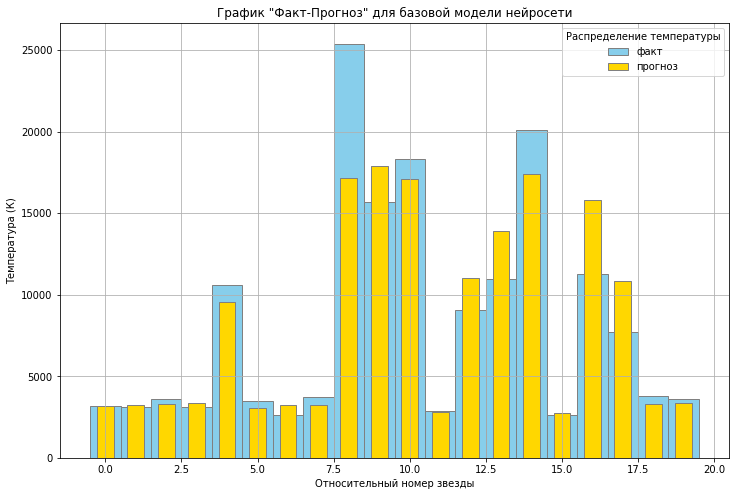

In [21]:
# построение графика "факт-прогноз" (для наглядности графика ограничимся первыми 20 звездами)
fig, ax = plt.subplots()
ax.bar(target_test[0:20].index, target_test.temperature[0:20], color = 'skyblue', edgecolor = 'grey', width = 1, label = 'факт')
ax.bar(target_test[0:20].index, target_test.predictions[0:20], color = 'gold', edgecolor = 'grey', width = 0.55, label = 'прогноз')
fig.set_figwidth(12)
fig.set_figheight(8)
ax.set_xlabel('Относительный номер звезды')
ax.set_ylabel('Температура (К)')
plt.grid()
plt.legend(title='Распределение температуры')
plt.title('График "Факт-Прогноз" для базовой модели нейросети')
plt.show()

### Вывод

- Нейросеть построена с пятью скрытыми слоями 
- Количество нейронов по слоям `18-324-324-324-324-324-1`
- Функция активации принята по всем слоям `ReLU`
- Функция потерь принята `L1Loss`
- Количество эпох принято в количестве `300`
- Наилучшее значение метрики RMSE на базовой модели равно `3881.19`

## Улучшение нейронной сети

In [22]:
# архитектура сети с четырьмя скрытыми слоями и выключением нейронов
class Model_improve(nn.Module):
    def __init__(self, dropout_1, dropout_2): 
        super(Model_improve, self).__init__()
        self.layer1 = nn.Linear(18, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(p=dropout_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=dropout_2)       
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.dp3 = nn.Dropout(p=dropout_1)        
        self.layer4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = nn.ReLU()
        self.dp4 = nn.Dropout(p=dropout_2)
        self.layer5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
        self.act5 = nn.ReLU()
        self.dp5 = nn.Dropout(p=dropout_1) 
        self.layer6 = nn.Linear(n_hidden_neurons_5, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.dp1(x)        
        x = self.layer2(x)
        x = self.act2(x)
        x = self.dp2(x)        
        x = self.layer3(x)
        x = self.act3(x)
        x = self.dp3(x)        
        x = self.layer4(x)
        x = self.act4(x)
        x = self.dp4(x)
        x = self.layer5(x)
        x = self.act5(x)
        x = self.dp5(x)
        x = self.layer6(x)
        return x 

In [23]:
%%time 
# введем функцию расчета rmse
def rmse_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
rmse_score = make_scorer(rmse_scorer)
# определим списки для записи и использования параметров
best_params = []
best_rmse = []
batches = []
best_model = []
# укажем размеры батчей для подбора
batch_sizes = [48, 65, 100]
# подбор параметров модели, сначала цикл по батчам далее подбор dropout в gridsearchcv
for batch_size in batch_sizes:
    num_batches = ceil(len(X_train_new)/batch_size)
    order = np.random.permutation(len(X_train_new))
    display('batch_size:', batch_size)
# случайная перестановка индексов объектов    
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_new[batch_indexes]
        y_batch = y_train[batch_indexes]
# создадим модель на основе нейросети для перебора параметров
        skorch_regressor = NeuralNetRegressor(
            module=Model_improve,
            optimizer=torch.optim.Adam, 
            max_epochs=300, 
            lr=1.0e-3,
            criterion =nn.L1Loss
        )
# параметры для перебора
        params = {
            'module__dropout_1': [0.2, 0.4],
            'module__dropout_2': [0.2, 0.4],
        }
# используем gridsearchcv для расчетов
        grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring=rmse_score, verbose=3) 
        grid.fit(X_batch, y_batch.reshape(-1,1)) 
        best_model.append(grid.best_estimator_)
        best_params.append(grid.best_params_)
        best_rmse.append(grid.best_score_)
        batches.append(batch_size)
# выведем на экран данные    
display('best_params_list:', best_params)        
display('best_rmse_list:', best_rmse) 
display('batches_list:', batches)

'batch_size:'

48

Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     7770.9146    13906.9424  0.0279
      2     7770.8589    13906.8701  0.0463
      3     7770.7832    13906.7676  0.0084
      4     7770.6631    13906.5879  0.0854
      5     7770.4751    13906.2754  0.0083
      6     7770.1152    13905.7490  0.0067
      7     7769.5039    13904.8955  0.0807
      8     7768.5273    13903.5322  0.0083
      9     7767.0596    13901.4062  0.0071
     10     7764.6567    13898.1934  0.0077
     11     7761.1680    13893.4482  0.0076
     12     7756.7842    13886.5137  0.0847
     13     7748.2749    13876.6924  0.0070
     14     7737.8105    13862.9189  0.0079
     15     7723.7788    13843.8525  0.0823
     16     7707.5361    13817.6904  0.0067
     17     7675.0688    13782.6465  0.0065
     18     7640.5181    13736.0557  0.0811
     19     7593.3413    13674.5840  0.0087
     20     7521

'batch_size:'

65

Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     9628.4082    11093.2920  0.0719
      2     9628.3428    11093.2031  0.0099
      3     9628.2510    11093.0527  0.0837
      4     9628.1152    11092.7832  0.0096
      5     9627.8682    11092.3154  0.0869
      6     9627.4414    11091.5312  0.0091
      7     9626.7188    11090.2646  0.0865
      8     9625.6035    11088.2637  0.0091
      9     9623.6738    11085.2090  0.0814
     10     9621.0430    11080.6152  0.0096
     11     9617.1123    11073.8516  0.0858
     12     9610.5039    11064.1680  0.0092
     13     9602.7773    11050.4238  0.0105
     14     9590.3008    11031.3242  0.0094
     15     9574.6172    11005.1006  0.0113
     16     9551.3125    10969.6152  0.0098
     17     9518.4004    10922.2754  0.0095
     18     9474.7588    10859.7910  0.0820
     19     9422.3867    10777.9336  0.0086
     20     9344

'batch_size:'

100

Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     9634.0264    13434.0342  0.0097
      2     9633.9492    13433.9189  0.0695
      3     9633.8350    13433.7217  0.0096
      4     9633.6367    13433.3643  0.0848
      5     9633.3057    13432.7324  0.0079
      6     9632.6680    13431.6797  0.0852
      7     9631.6709    13429.9688  0.0076
      8     9630.0820    13427.2676  0.0084
      9     9627.5771    13423.1035  0.0859
     10     9623.5615    13416.8848  0.0115
     11     9617.8506    13407.7451  0.0832
     12     9608.8037    13394.6631  0.0109
     13     9597.0371    13376.1953  0.0820
     14     9580.3232    13350.5645  0.0088
     15     9557.5283    13315.4238  0.0817
     16     9524.6387    13268.0361  0.0089
     17     9477.1523    13205.1201  0.0860
     18     9418.8711    13122.2285  0.0081
     19     9344.4844    13013.8613  0.0092
     20     9245

'best_params_list:'

[{'module__dropout_2': 0.4, 'module__dropout_1': 0.4},
 {'module__dropout_2': 0.4, 'module__dropout_1': 0.4},
 {'module__dropout_2': 0.4, 'module__dropout_1': 0.4},
 {'module__dropout_2': 0.4, 'module__dropout_1': 0.4},
 {'module__dropout_2': 0.2, 'module__dropout_1': 0.2},
 {'module__dropout_2': 0.4, 'module__dropout_1': 0.2},
 {'module__dropout_2': 0.2, 'module__dropout_1': 0.2},
 {'module__dropout_2': 0.2, 'module__dropout_1': 0.2},
 {'module__dropout_2': 0.4, 'module__dropout_1': 0.2}]

'best_rmse_list:'

[6140.060546875,
 6527.55810546875,
 6734.646809895833,
 6929.716796875,
 4826.363525390625,
 6456.042805989583,
 6733.29296875,
 5496.232259114583,
 5753.083170572917]

'batches_list:'

[48, 48, 48, 48, 65, 65, 65, 100, 100]

CPU times: user 23min 57s, sys: 25 s, total: 24min 22s
Wall time: 25min 49s


In [24]:
# уберем ограничение на отображаемый размер столбцов
pd.set_option('display.max_colwidth', None)
# обозначим параметры как столбцы пандас
results1 = pd.Series(best_params)
results2 = pd.Series(best_rmse)
results3 = pd.Series(batches)
# выведем данные как таблицу после расчетов на предыдущем шаге
results = pd.concat([results1, results2, results3], axis= 1)
results.columns = ['dropout_params', 'best_rmse', 'batches']
display(results)

,dropout_params,best_rmse,batches
0,"{'module__dropout_2': 0.4, 'module__dropout_1': 0.4}",6140.060547,48
1,"{'module__dropout_2': 0.4, 'module__dropout_1': 0.4}",6527.558105,48
2,"{'module__dropout_2': 0.4, 'module__dropout_1': 0.4}",6734.646810,48
3,"{'module__dropout_2': 0.4, 'module__dropout_1': 0.4}",6929.716797,48
4,"{'module__dropout_2': 0.2, 'module__dropout_1': 0.2}",4826.363525,65
5,"{'module__dropout_2': 0.4, 'module__dropout_1': 0.2}",6456.042806,65
6,"{'module__dropout_2': 0.2, 'module__dropout_1': 0.2}",6733.292969,65
7,"{'module__dropout_2': 0.2, 'module__dropout_1': 0.2}",5496.232259,100
8,"{'module__dropout_2': 0.4, 'module__dropout_1': 0.2}",5753.083171,100


In [25]:
# обозначим модель для тестов с подобранными параметрами на предыдущих шагах
torch.use_deterministic_algorithms(True)
model_second = Model_improve(0.2, 0.2) 
# обозначим все параметры заново для избежания перезаписи
optimizer_4 = torch.optim.Adam(model_first.parameters(), lr=1e-3)
loss_4 = nn.L1Loss()
batch_size_4 = 65
num_epochs_4 = 301
num_batches_4 = ceil(len(X_train_new)/batch_size_4)
# используем цикл для расчета предсказаний на тестовой выборке
for epoch_4 in range(num_epochs_4):
    order_4 = np.random.permutation(len(X_train_new))
# используем батчи
    for batch_idx_4 in range(num_batches_4):
        start_index_4 = batch_idx_4 * batch_size_4
        optimizer_4.zero_grad()
        batch_indexes_4 = order_4[start_index_4:start_index_4+batch_size_4]
        X_batch_4 = X_train_new[batch_indexes_4]
        y_batch_4 = y_train[batch_indexes_4]
        preds_4 = model_first.forward(X_batch_4).flatten()
        loss_value_4 = loss(preds_4, y_batch_4)
        loss_value_4.backward()
        optimizer_4.step()
# рассчитаем метрику каждые 100 эпох для наглядности
    if epoch_4 % 100 == 0:
        model_first.eval()
        test_preds_4 = model_first.forward(X_test_new)
        rmse_4 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds_4.detach().numpy()))
        display(f'epoch:{epoch_4}, rmse:{rmse_4}')

'epoch:0, rmse:4020.962571325428'

'epoch:100, rmse:4256.169404523274'

'epoch:200, rmse:4383.1157867434895'

'epoch:300, rmse:4439.641426962317'

In [26]:
# подготовка таблицы с данными
test_preds_new = test_preds_4.detach().numpy()
test_preds_new = pd.DataFrame(test_preds_new, index=features_test.index)
target_test2 = pd.DataFrame(target_test2)
target_test2 = target_test2.join(test_preds_new)
target_test2.columns = ['temperature_test', 'predictions_test']
target_test2.reset_index(drop= True , inplace= True )
display(target_test2.head())

,temperature_test,predictions_test
0,3150,3393.630859
1,3129,3398.754883
2,3605,3615.959961
3,3095,3489.647217
4,10574,15079.111328


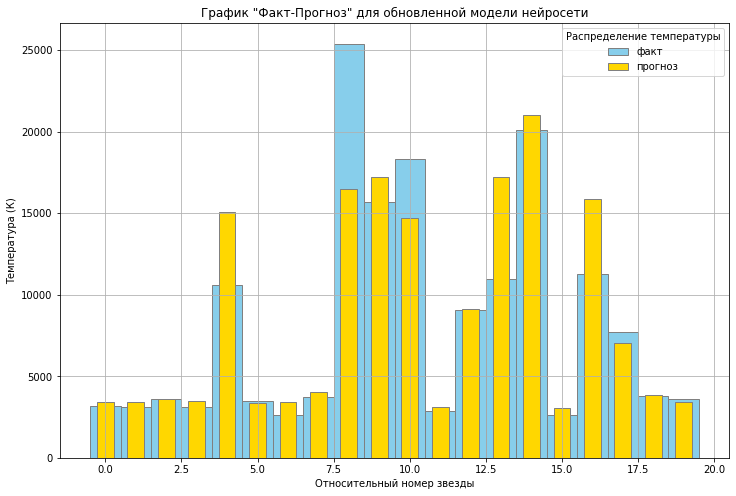

In [27]:
# построение графика "факт-прогноз" (для наглядности графика ограничимся первыми 20 звездами)
fig1, ax1 = plt.subplots()
ax1.bar(target_test2[0:20].index, target_test2.temperature_test[0:20], color = 'skyblue', edgecolor = 'grey', width = 1, label = 'факт')
ax1.bar(target_test2[0:20].index, target_test2.predictions_test[0:20], color = 'gold', edgecolor = 'grey', width = 0.55, label = 'прогноз')
fig1.set_figwidth(12)
fig1.set_figheight(8)
ax1.set_xlabel('Относительный номер звезды')
ax1.set_ylabel('Температура (К)')
plt.grid()
plt.legend(title='Распределение температуры')
plt.title('График "Факт-Прогноз" для обновленной модели нейросети')
plt.show()

### Вывод

- После внедрения в модель `dropout` и `размера батчей` метрика на тестовой выборке составила `4439.64`
- Размер батча принят равным `65` после подбора параметров на `GridSearchCV`
- Регуляризация `dropout` для слоев 1-3-5 принята в размере `0.2` после подбора параметров на `GridSearchCV`
- Регуляризация `dropout` для слоев 2-4 также принята в размере `0.2` после подбора параметров на `GridSearchCV`